# Week 12 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Ville Cantory <canto063@umn.edu>

# GPU programming: algorithms

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL ->  Introduction to GPUs --> **More advanced GPU Algorithms**

GPU's are Graphics Processing Units that have a large number of cores that can operate in parallel on data. Compare that to CPU's, which have a low number of cores (typically 4-8 for desktops, and 16-128 for single servers). Originally, these were used primarily to render graphics for games, but people quickly realized that these highly parallel architectures could be leveraged for general purpose computations (GPGPU).

Each core of a CPU has its own local cache (L1) which is rather small, but has very fast access. All the CPU's will share a larger L3 cache, which is some sort of faster-than-global memory for this set of cores, but still slower than L1 and L2 caches.


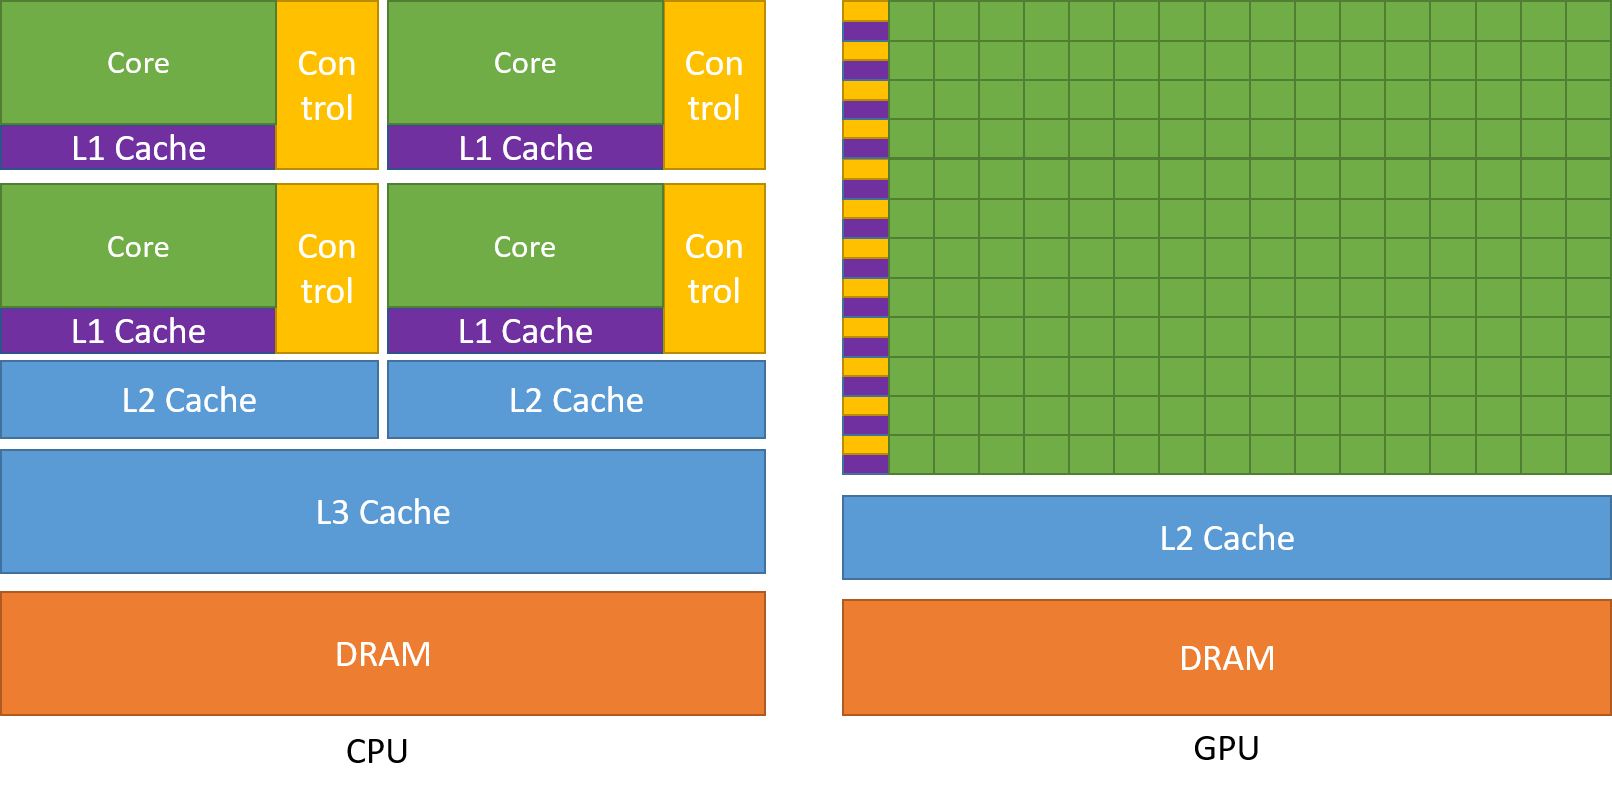

Compare that to a GPU, where a lower level cache is shared by many cores. Each core is less powerful and has less cache space that it can use itself, but this is made up for by having many more cores that can run at once.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [10]:
from numba import jit, njit, vectorize, cuda
import math
import numpy as np

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


### Torch:

### Dask:

# Import

In [12]:
import numpy as np
import pandas as pd
from multiprocessing import Pool, Process
import torch

In [13]:
import matplotlib.pyplot as plt

## Kernels
**Kernel** functions are functions that will be executed on the GPU to call a number of threads.

Each thread has a unique ID in a particular dimension, defined by a **thread block**, which can be 1D, 2D, or 3D. Each block can have up to 1024 threads, but multiple thread blocks can run;  this gives the total number of threads running as threads_per_block * num_blocks.

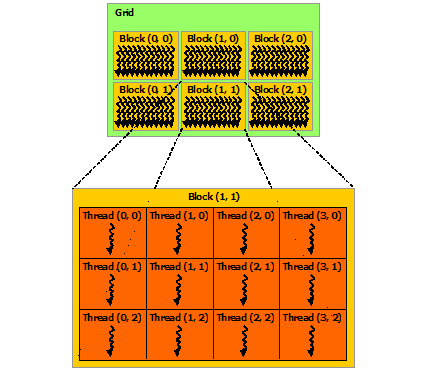


In [14]:
!pip install pycuda # install cuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [15]:
mod = SourceModule("""
  __global__ void matmul_kernel(float* d_M, float* d_N, float* d_P, int width)
  {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int column = blockIdx.x * blockDim.x + threadIdx.x;

    if((row < width) && (column < width))
    {
      float value = 0;
      // each thread computes one element of the block sub-matrix
      for (int k = 0; k < width; ++k)
      {
        value += d_M[row * width + k] * d_N[k * width + column];
      }
      d_P[row * width + column] = value;
    }
  }
  """)

In [16]:
# In python
from pycuda import gpuarray

func = mod.get_function("matmul_kernel")

# Make 2 256x1 arrays of 32 bit floats -- this represents 2 16x16 matrices
M = np.random.rand(16, 16).astype(np.float32)
N = 2.0 * np.random.rand(16, 16).astype(np.float32)
d_P = np.zeros((M.shape[0], N.shape[1]), dtype=np.float32)


M_matmul_kernel_gpu = gpuarray.to_gpu(M)
N_matmul_kernel_gpu = gpuarray.to_gpu(N)

d_P_gpu = gpuarray.empty(shape=d_P.shape, dtype=np.float32)
func(M_matmul_kernel_gpu, N_matmul_kernel_gpu, d_P_gpu, np.int32(16), block=(16, 16, 1))

d_P_ret = d_P_gpu.get()
print(d_P_ret)

[[ 9.472785  10.144555  12.271766  11.863788   8.586265  12.116186
   9.777919   9.426534   8.992558  10.6328125 10.952967  11.823655
  11.550015  11.537526   8.440866   7.6795397]
 [ 7.3097334  7.8075576 10.09781    7.0792637  6.5101748  6.8218293
   7.9527645  7.035666   6.916747   6.1951632  8.218541   7.5434437
   8.368241   7.880992   5.162247   5.5695863]
 [ 8.265831   8.102084  10.172475   8.982933   6.6870193  9.794215
   9.26316    8.250381   6.6965938  7.285846   7.497503   9.246741
   8.493444   9.421902   5.9392767  4.816692 ]
 [ 5.0208344  6.709394   5.7564726  6.826034   5.48113    5.9173203
   6.1196866  4.7285366  4.725212   6.0330486  6.3969116  7.201817
   6.981288   6.7091765  3.7251403  3.0393   ]
 [ 8.806457   9.886553  11.355331  11.012757   8.254272  11.319077
   9.993939   9.211897   9.47902   10.757683   9.865817  11.001343
  11.9485    11.147543   8.715914   7.5867276]
 [ 6.7146554  9.244771   9.814299   9.81557    6.935368   9.835027
   8.3864355  8.371162   

We did matrix multiplication by treating it as two 16x16 arrays multiplying by eachother, but in C, that would be represented as a float**, and if ptr = *data, would make our pointer point to the first row of the matrix. *ptr will return index 0 of the first row, and *(ptr + 1) will return index 1 of the first row. ptr = *(data + 1) will give us the second row, and then that can be traversed similarily.

For things that are accessed frequently, shared memory should be be used when possible. This will lead to one access in global memory to read it and copy it to shared memory, rather than having to do an access in global memory every time it needs to be accessed. This will also be preferable to placing the data in a register, as then the data is going to be private to one thread, rather than accessible from all threads in a warp (a set of 32 threads that operate together).

But, the tradeoff of shared memory is that it's smaller, so less data can fit into there. Sometimes, portions of global memory will need to be partitioned into tiles so that each tile fits into shared memory, and then threadblocks can operate on that tile.




<h1> Histograms </h1>

Histograms are an interesting problem for parallel processing.
While quite often, a programmer expects a particular thread writes a subset of output that other threads do not write to.
However, in a histogram, a kernel will take some input subset, perform some computation, (perhaps something as simple as binning), and need to modify the output of an element; multiple threads may need to do this to the same output element at the same time.
Therrefore, coordination amongst threads is imperative.
The most simple way to get around this is using atomic operations.

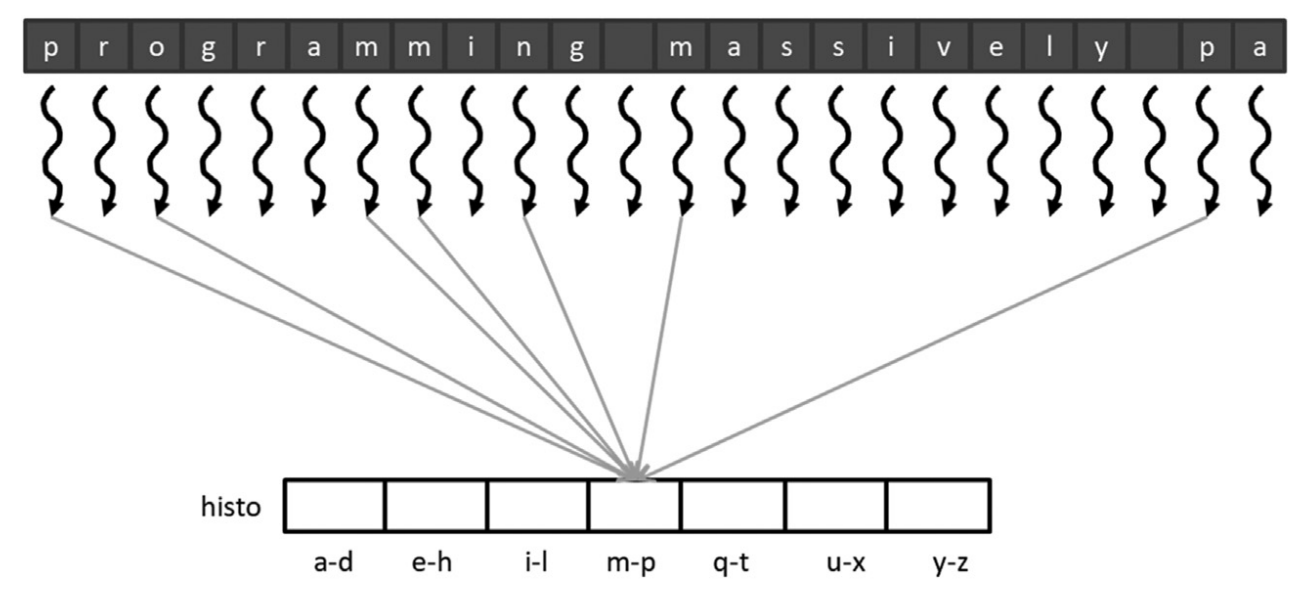


Each thread reads the assigned input element and increments the appropriate bin with a count, or whatever calculation the thread is supposed to perform.

However, just writing something out like:

```
int idx = threadIdx.x;
output[idx] = input[idx] * 10;
```

will certainly lead to overwrites, while something like

```
int idx = threadIdx.x;
output[idx] += input[idx] * 10;
```

will lead to incorrect results? Why? Maybe you can try running the code below.

In [17]:
from pycuda.compiler import SourceModule
from pycuda import driver, gpuarray
import pycuda.autoinit
import numpy as np

# --- CUDA Kernel ---
mod = SourceModule("""
__global__ void histogram(int *data, int *hist, int size, int num_bins)
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < size)
    {
        int bin = data[tid];
        if (bin < num_bins)
        {
            hist[bin] += 1;
        }
    }
}
""")

# --- Python-side Setup ---
hist_kernel = mod.get_function("histogram")

# Example data: 1000 integers in range [0, 15]
num_bins = 16
data = np.random.randint(0, num_bins, size=1024).astype(np.int32)
hist = np.zeros(num_bins, dtype=np.int32)

# Copy to GPU
data_gpu = gpuarray.to_gpu(data)
hist_gpu = gpuarray.to_gpu(hist)

# Launch kernel: One thread per input value
block_size = 256
grid_size = int(np.ceil(data.size / block_size))
hist_kernel(data_gpu, hist_gpu, np.int32(data.size), np.int32(num_bins), block=(block_size,1,1), grid=(grid_size,1))

# Get result
hist_result = hist_gpu.get()
print("Histogram:", hist_result)

Histogram: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [18]:
from pycuda.compiler import SourceModule
from pycuda import driver, gpuarray
import pycuda.autoinit
import numpy as np

# --- CUDA Kernel ---
mod = SourceModule("""
__global__ void histogram(int *data, int *hist, int size, int num_bins)
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < size)
    {
        int bin = data[tid];
        if (bin < num_bins)
        {
            atomicAdd(&hist[bin], 1);
        }
    }
}
""")

# --- Python-side Setup ---
hist_kernel = mod.get_function("histogram")

# Example data: 1000 integers in range [0, 15]
num_bins = 16
data = np.random.randint(0, num_bins, size=1000).astype(np.int32)
hist = np.zeros(num_bins, dtype=np.int32)

# Copy to GPU
data_gpu = gpuarray.to_gpu(data)
hist_gpu = gpuarray.to_gpu(hist)

# Launch kernel: One thread per input value
block_size = 256
grid_size = int(np.ceil(data.size / block_size))
hist_kernel(data_gpu, hist_gpu, np.int32(data.size), np.int32(num_bins), block=(block_size,1,1), grid=(grid_size,1))

# Get result
hist_result = hist_gpu.get()
print("Histogram:", hist_result)

Histogram: [63 53 56 81 53 68 51 52 69 77 56 63 80 56 57 65]


To be clear, an atomic works by locking access to a  variable so one thread can safely acccess it at a time, preventing race conditions.

Remember, atomic operations do not enforce thread execution order.
When any operation executes, it could be that thread2 executes entirely before thread1 for the whole kernel (devolving to worst-case sequential runtime), to anything such as every thread doing its computations simultaneously, then atomically writing to output.

This sequential writing, known as **serializing**, can drastically degrade performance.
Consider also if this happens when writing to something in global memory instead of shared memory -- now you have a massive throughput problem.
With DRAM, there are strategies of writing to many DRAM banks at once to mitigate some of the access costs, but it's a lot more work.
The CUDA compiler tries to write atomic operations at minimum into memory stored in the last-level cache access (think L3 on a CPU), but there's not a guarantee that this can occur; however, if this occurs, the throughput of atomic operations does get increased dramatically.

A smart way to try and ensure a cache is used is to write intermediary values into shared memory, and after all computations occur, atomically write them to a histogram!!! You can see some great examples of this occuring in a periodfinding algorithm here https://github.com/ZwickyTransientFacility/periodfind/blob/03142fa0169a50cbdace8b2fda70e61b099b2ce7/periodfind/cuda/aov.cu#L44



<h3> How should we write atomics for histogram algorithms? </h3>

Generally, get your code working, worry about performance later* (with a little consideration for performance from the start, but not so much as to impede getting a functioning algorithm).
Algorithms can wait.

For example, this code from a phase-bin kernel runs alright, and is easy to write

```
    for (size_t idx = threadIdx.x; idx < length; idx += blockDim.x) {
        float t = times[idx];
        float t_corr = t - pdt_corr * t * t;
        float folded = fabsf(modff(t_corr / period, &i_part));

        float mag = mags[idx];

        size_t bin = aov.PhaseBin(folded);

        for (size_t i = 0; i < aov.NumPhaseBinOverlap(); i++) {
            size_t idx = (bin + i) % aov.NumPhaseBins();

            atomicAdd(&sh_count[bin], 1);
            atomicAdd(&sh_sums[bin], mag);
            atomicAdd(&sh_sq_sums[bin], mag * mag);
        }
    }
```

while this version is exactly the same, but minimizes both branch statements, which incur large overheads on GPUs, and reduces the number of atomic writes by numPhaseBinOverlap each invocation:

```
    for (size_t idx = threadIdx.x; idx < length; idx += blockDim.x) {
        float t = times[idx];
        float t_corr = t - pdt_corr * t * t;
        float folded = fabsf(modff(t_corr / period, &i_part));
        float mag = mags[idx];
        size_t bin = aov.PhaseBin(folded);

        // Remove the for loop and amortize out how often the operations would occur
        atomicAdd(&sh_count[bin], num_phase_bin_overlap);
        atomicAdd(&sh_sums[bin], num_phase_bin_overlap * mag);
        atomicAdd(&sh_sq_sums[bin], num_phase_bin_overlap * mag * mag);
    }
```

There are a lot more things you can look into for histogram computations -- for instance, there are good algorithmic ways to try to maximize register usage within a kernel.
Thread coarsening is a way of having each threads process multiple elements to minimize how many blocks are spawned, and how many atomic writes each thread will have to do -- often can be combined with shared memory usage.
The  effectiveness of this has to be evaluated per use case though, to make sure you don't run out of registers, or other local memory limitations.

## Parallel Prefix Sum (Scan)

Often times, a recusion where each item in a series is defined by previous terms, it can be parallelized as a parallel scan rather than treated sequentially.
The work per item is generally more, but overall computation time is less.

This is typically accomplished using a Reduction Tree, where partial sums across each level are computed, and then shared in output elements.

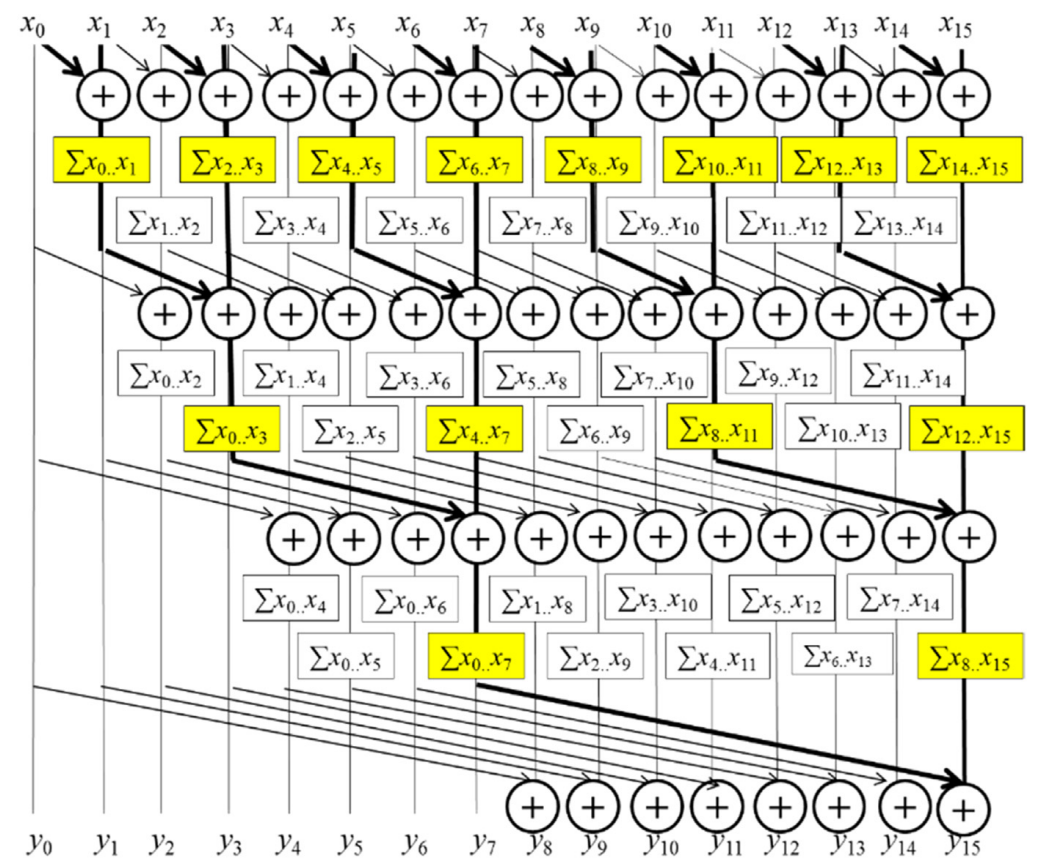

Lets say we want to compute the prefix sum of an array of N elements.
There are inclusive scan, and exclusive scans*.
We'll talk about inclusive scans, using shared memory.

Initially, each thread could be assigned one index of the input array; ie, for 8 elements, we launch 8 threads per block.

We'll be operating on the input data potentially quite a bit, so we'll need to copy to dhared memory and then synchronize the copy.

After, we'll build a partial sum tree.
We call this the Up Sweep, or Reduction phase, wherre each thread looks further in the array, adds a neighbouring value, and updates itself.

In the second phase, this algorithm receives the content of a position s away elements away.
This continues to progress until all threads have accumulated.


In [33]:

import time

SECTION_SIZE = 1024

mod = SourceModule(f"""
#define SECTION_SIZE {SECTION_SIZE}

__global__ void Kogge_Stone_scan_kernel(float *X, float *Y, unsigned int N){{
    __shared__ float XY[SECTION_SIZE];
    unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;

    if(i < N) {{
        XY[threadIdx.x] = X[i];
    }} else {{
        XY[threadIdx.x] = 0.0f;
    }}

    for(unsigned int stride = 1; stride < blockDim.x; stride *= 2) {{
        __syncthreads();
        float temp = 0;
        if(threadIdx.x >= stride)
            temp = XY[threadIdx.x] + XY[threadIdx.x - stride];
        __syncthreads();
        if(threadIdx.x >= stride)
            XY[threadIdx.x] = temp;
    }}

    if(i < N) {{
        Y[i] = XY[threadIdx.x];
    }}
}}
""")

# Timing
start = cuda.Event()
end = cuda.Event()

start.record()
scan_kernel = mod.get_function("Kogge_Stone_scan_kernel")
end.record()
end.synchronize()

N = 65536
X = np.random.rand(N).astype(np.float32)
Y = np.zeros_like(X)

X_gpu = gpuarray.to_gpu(X)
Y_gpu = gpuarray.empty_like(X_gpu)

block_size = SECTION_SIZE
grid_size = (N + block_size - 1) // block_size

scan_kernel(X_gpu, Y_gpu, np.uint32(N), block=(block_size,1,1), grid=(grid_size,1))

result = Y_gpu.get()

print("Input:", X[:10])
print("Prefix Sum:", result[:10], "Time: ", start.time_till(end))

start_time_np = time.perf_counter()
npresult = np.cumsum(X)
end_time_np = (time.perf_counter() - start_time_np) * 1000
npresult_trunc = npresult[:10]
print("Numpy cumsum for check:", np.cumsum(X)[:10], "Time: ", end_time_np)

Input: [0.45548466 0.51603675 0.43716714 0.246538   0.2032831  0.72689044
 0.02002538 0.33752847 0.45090207 0.00980597]
Prefix Sum: [0.45548466 0.9715214  1.4086885  1.6552265  1.8585097  2.5854
 2.6054254  2.9429538  3.393856   3.403662  ] Time:  0.23161600530147552
Numpy cumsum for check: [0.45548466 0.9715214  1.4086885  1.6552266  1.8585097  2.5854
 2.6054256  2.942954   3.393856   3.403662  ] Time:  0.3562339998097741
